In [1]:
import os
import sys
import h5py
import PIL
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src.likelihoods import GaussianBagLikelihood
from src.models import VariationalGP

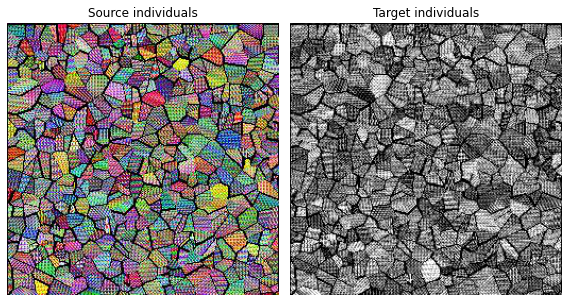

In [2]:
source = np.asarray(PIL.Image.open('optical.jpg'))
target = np.asarray(PIL.Image.open('sar.jpg'))[..., 0]
annotation = h5py.File('annotation_0.h5', 'r')['data'][..., 0]

fig, ax = plt.subplots(1, 2, figsize=(8, 6))

ax[0].imshow(source)
ax[0].axis('off')
ax[0].set_title('Source individuals')
ax[1].imshow(target, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Target individuals')

plt.tight_layout()
plt.show()

In [3]:
def extract_bag(img, mask):
    pixels_features = img[mask]
    pixels_locations = np.argwhere(mask)
    bag = np.hstack([pixels_locations, pixels_features])
    return bag

In [4]:
# tweak source and tarfget
target = source[..., -1]
source = source[..., :2]
print(target.shape)
print(source.shape)

(256, 256)
(256, 256, 2)


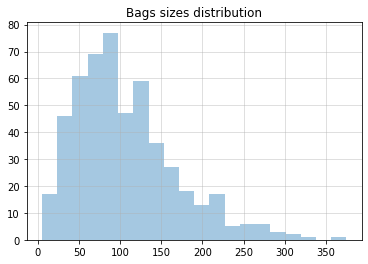

In [5]:
# Determine boolean masks corresponding to each bag
valid_pixels = annotation[annotation > 0]
n_bags = len(np.unique(valid_pixels))
bags_masks = [annotation == idx for idx in np.unique(valid_pixels)]

# Extract bags and and their respective mean
bags = [torch.from_numpy(extract_bag(source, mask)).float() for mask in bags_masks]
bags_targets = torch.FloatTensor([target[mask].mean() for mask in bags_masks])

stacked_bags = torch.cat(bags)
bags_sizes = torch.IntTensor(list(map(len, bags)))

# Plot bag sizes distribution
plt.figure()
sns.distplot(bags_sizes.numpy(), kde=False)
plt.title("Bags sizes distribution")
plt.grid(alpha=0.5)
plt.show()

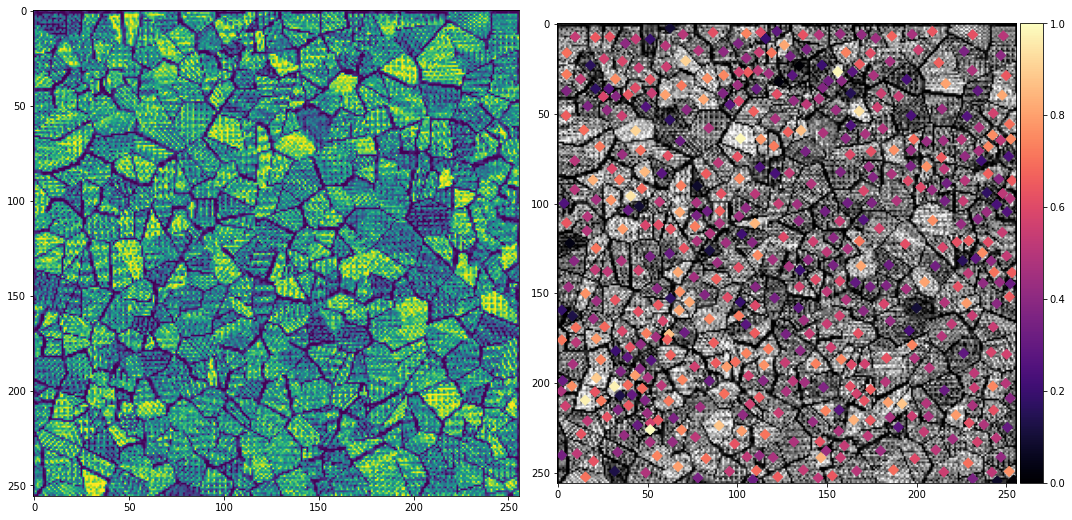

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

ax[0].imshow(source[..., 0])

ax[1].imshow(target, cmap='gray')
centroids = np.stack([x[:, :2].numpy().mean(axis=0) for x in bags])
foo = bags_targets.numpy()
normalized_bags_targets = (foo - foo.min()) / (foo.max() - foo.min())

centroids_colors = [plt.cm.magma(x) for x in normalized_bags_targets]
ax[1].scatter(centroids[:, 1], centroids[:, 0], c=centroids_colors, s=50, marker='D')
mappable = plt.cm.ScalarMappable(cmap='magma')
mappable.set_array(normalized_bags_targets)
cbar = fig.colorbar(mappable, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

### Bag dataset

In [7]:
class BagDataset(Dataset):
    
    def __init__(self, bags, bags_targets):
        self.bags = [x.clone() for x in bags]
        self.bags_targets = bags_targets.clone()

    def __getitem__(self, idx):
        bag = self.bags[idx]
        target = self.bags_targets[idx]
        return bag, target
    
    def __len__(self):
        return len(self.bags)
    
    def __repr__(self):
        output = f"Number of bags : {len(self)} \n"
        output += f"Number of individuals : {sum(map(len, self.bags))}"
        return output
    
dataset = BagDataset(bags=bags, bags_targets=bags_targets)
dataset

Number of bags : 511 
Number of individuals : 54427

In [8]:
def list_collate(batch):
    data, target = zip(*batch)
    return list(data), torch.Tensor(target)

### Setup model

In [9]:
from gpytorch import means, kernels

In [10]:
landmark_points = torch.stack([x.mean(dim=0) for x in bags])
print("Landmark points : ", landmark_points.shape)

Landmark points :  torch.Size([511, 4])


In [13]:
mean_module = means.LinearMean(input_size=4)
spatial_kernel = kernels.ScaleKernel(kernels.RBFKernel(active_dims=torch.tensor([0, 1]), ard_num_dims=2))
pixel_kernel = kernels.ScaleKernel(kernels.RBFKernel(active_dims=torch.tensor([2, 3]), ard_num_dims=2))
covar_module = spatial_kernel + pixel_kernel

model = VariationalGP(landmark_points=landmark_points,
                      mean_module=mean_module,
                      covar_module=covar_module)

likelihood = GaussianBagLikelihood()

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(stacked_bags))

### Learn variational posterior

In [14]:
epochs = 50

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.1)


epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for epoch in epoch_iter:
    dataloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True, collate_fn=list_collate)
    bag_iter = tqdm.notebook.tqdm(dataloader, desc="Bag minibatch")
    for batch_bags, batch_targets in bag_iter:
        bags_sizes = torch.IntTensor(list(map(len, batch_bags)))
        optimizer.zero_grad()
        variational_posterior_distribution = model(torch.cat(batch_bags))
        loss = -elbo(variational_posterior_distribution, batch_targets.unsqueeze(0),
                     bags_sizes=bags_sizes)
        epoch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
print("Train ELBO = ", torch.exp(-loss).item())



Train ELBO =  0.005337245296686888


In [16]:
N = 100
P = 100

x = np.linspace(0, N - 1, N)
y = np.linspace(0, P - 1, P)

pixels_locations = np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
inputs = np.concatenate([pixels_locations, source[:N, :P].reshape(-1, 2)], axis=1)
inputs = torch.from_numpy(inputs).float()
print(inputs.shape)

torch.Size([10000, 4])


In [17]:
model.eval()
likelihood.eval()

with torch.no_grad():
    outputs = model(inputs)

In [18]:
mean_pred = outputs.mean.numpy().reshape(N, P)
lower_bound, upper_bound = outputs.confidence_region()
confidence = upper_bound.sub(lower_bound).numpy().reshape(N, P)

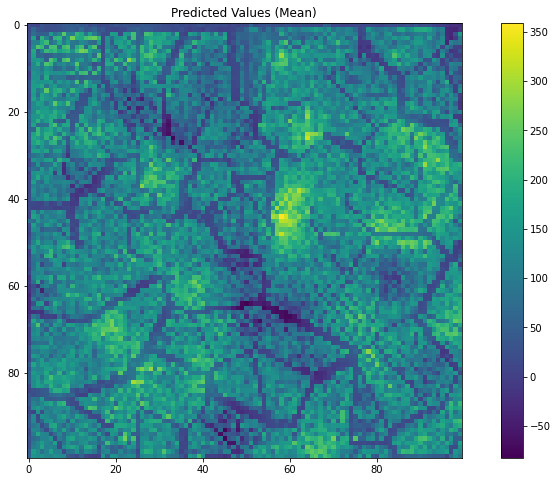

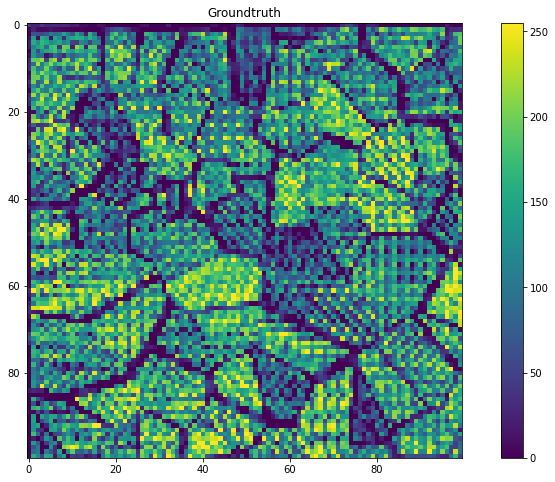

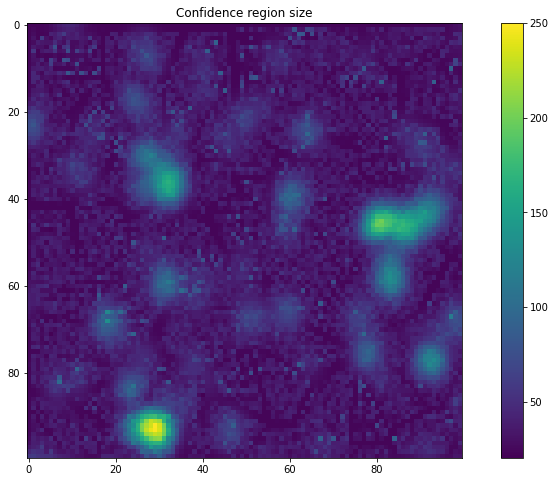

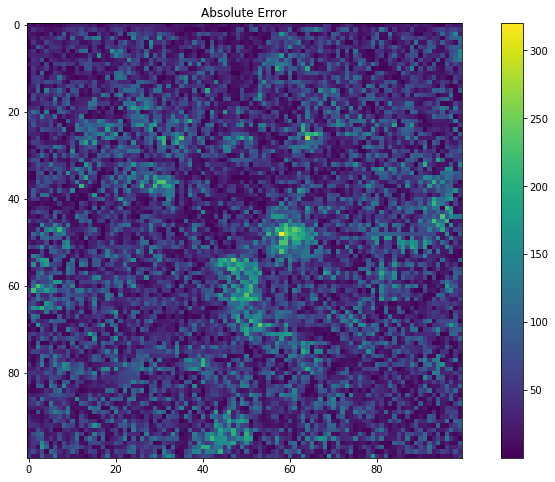

In [19]:
# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(14, 8))
ax_plot(f, observed_ax, mean_pred, 'Predicted Values (Mean)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(14, 8))
ax_plot(f, observed_ax2, target[:N, :P], 'Groundtruth')

# Plot confidence region size
f, observed_ax3 = plt.subplots(1, 1, figsize=(14, 8))
ax_plot(f, observed_ax3, confidence, 'Confidence region size')

# Plot absolute error
f, observed_ax3 = plt.subplots(1, 1, figsize=(14, 8))
ax_plot(f, observed_ax3, np.abs(mean_pred - target[:N, :P]), 'Absolute Error')